# Summarize Text

## Overview

LLMs are a great tool for summarizing text content, given their proficiency in understanding and generating text.

In the context of [RAG (retrieval-augmented generation)](https://github.com/TCLee/rag-langchain), summarizing text can help distill the information in a large number of retrieved documents to provide context for a LLM.

In this notebook, we'll go over how to summarize text content with 3 different strategies. First, we split or chunk a long piece of text into "sub-documents". Then, we'll explore the following strategies:
- **Stuff**: Simply "stuff" all the documents into a single prompt. This is the simplest approach if the whole document can fit inside the model's context window.
- **Map-Reduce**: Summarize each sub-document in _parallel_ in a `map` step and then `reduce` or consolidate the summaries into a final summary.
- **Iterative Refinement**:
    1. Summarize the first sub-document.
    2. Refine/update the result based on the next sub-document.
    3. Repeat through the sequence of sub-documents until finished.

> The code in this notebook is adapted from the [LangChain tutorial: Summarize Text](https://python.langchain.com/docs/tutorials/summarize_text/).

## Environment variables

Before running the next cell, please make sure you have setup the `.env` file in the project directory as described in [`README.md`](README.md).

Next, we will load in the necessary environment variables for this notebook using [`dotenv`](https://github.com/theskumar/python-dotenv):


In [1]:
from dotenv import load_dotenv

_ = load_dotenv()

## Run models locally

Before we begin, please make sure you followed the instructions in the [`README.md`](README.md) to setup [`Ollama`](https://ollama.com/) and [`Llama 3.2`](https://ollama.com/library/llama3.2).

Two important benefits of running LLMs locally on your own device are:
- **Privacy**: Your data is not sent to a third party, and it is not subject to the terms of service of a commercial service.
- **Cost**: There is no inference fee, which is important for token-intensive applications (e.g., summarization, agent simulations)

In this notebook, we'll be using `Llama 3.2` with size of `3B` parameters. We'll use `Ollama` to serve the LLM and run inference locally.

> See also: [How to run models locally](https://python.langchain.com/docs/how_to/local_llms/)

Let's load the model into memory and try it out:

In [3]:
from langchain_ollama import ChatOllama

chat_model = ChatOllama(
    model="llama3.2:3b",
    temperature=0
)

response = chat_model.invoke(
    "Write a brief summary of the story "
    "`The Cask of Amontillado` by Edgar Allan Poe."
)

print(response.content)

"The Cask of Amontillado" is a short story by Edgar Allan Poe, first published in 1846. The narrative follows Montresor, a nobleman seeking revenge against his acquaintance, Fortunato, who he believes has wronged him.

Montresor invites Fortunato to his family's underground catacombs for a night of revelry and wine tasting. Unbeknownst to Fortunato, Montresor intends to punish him for an unspecified offense. As the evening progresses, Montresor leads Fortunato deeper into the catacombs, where he becomes increasingly disoriented and trapped.

Using his knowledge of the labyrinthine tunnels, Montresor expertly manipulates Fortunato's perceptions, making him believe that they are searching for a rare bottle of Amontillado wine. As the story unfolds, Montresor's actions become more sinister, ultimately leading to Fortunato's gruesome and fatal demise.

The tale is known for its masterful use of suspense, symbolism, and psychological manipulation, leaving readers with a sense of unease and 

We can see that `Llama 3.2` has been pre-trained on the [The Cask of Amontillado](https://www.gutenberg.org/ebooks/1063) by [Edgar Allan Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe). So, it has an existing knowledge of this story.

## Document Loading

Let's load in a sample text file that we will use for summarization.

The sample file is a short story by [Edgar Allan Poe](https://en.wikipedia.org/wiki/Edgar_Allan_Poe) titled ["The Cask of Amontillado"](https://www.gutenberg.org/ebooks/1063). This and other short stories are freely available on [Project Gutenberg](https://www.gutenberg.org/).

In [4]:
from langchain_community.document_loaders import TextLoader

text_loader = TextLoader(
    file_path="data/the-cask-of-amontillado.txt", 
    encoding="utf-8"
)
docs = text_loader.load()

In [5]:
print(
    docs[0].page_content[:500]
)

The Cask of Amontillado
by Edgar Allan Poe


The thousand injuries of Fortunato I had borne as I best could, but
when he ventured upon insult, I vowed revenge.  You, who so well know
the nature of my soul, will not suppose, however, that I gave utterance
to a threat.  _At length_ I would be avenged; this was a point definitely
settled--but the very definitiveness with which it was resolved,
precluded the idea of risk.  I must not only punish, but punish with
impunity.  A wrong is unredressed whe


## Stuff: Summarize text in a single LLM call

For models with larger context windows, we can summarize a long document via a single LLM call. Here we use `Llama 3.2` that supports a context length of `128K` tokens.

LangChain implements a simple pre-built chain [`create_stuff_documents_chain`](https://python.langchain.com/api_reference/langchain/chains/langchain.chains.combine_documents.stuff.create_stuff_documents_chain.html)
that "stuffs" a prompt with the desired context for summarization. It takes a list of documents, insert them all into a prompt, and pass that prompt to an LLM.

> See also: [How to summarize text in a single LLM call](https://python.langchain.com/docs/how_to/summarize_stuff/)

Let's take a look at the prompt used for summarizing the story:

In [21]:
from langchain_core.prompts import PromptTemplate

summarize_template = PromptTemplate.from_file(
    "prompts/summarize_template.txt"
)

summarize_template.pretty_print()

Write a plot summary of the following story in under 500 words. Only use the information provided in the story below to produce the plot summary. Your final answer should only be the plot summary and nothing else.

Story to summarize:
{context}

Plot summary:


In [22]:
from langchain.chains.combine_documents \
    import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt_template = ChatPromptTemplate.from_messages(
    messages=[        
        ("human", summarize_template.template)
    ]
)

# Instantiate chain
stuff_chain = create_stuff_documents_chain(
    llm=chat_model, 
    prompt=prompt_template
)

# Invoke chain
result = stuff_chain.invoke(
    input={"context": docs}
)

print(result)

The story is about an unnamed narrator who seeks revenge against his acquaintance, Fortunato, for an unspecified offense. The narrator invites Fortunato to his family's catacombs to show him a rare bottle of Amontillado wine. Once they are alone in the catacombs, the narrator chains Fortunato to a wall and begins to brick him up alive, sealing him in the tomb.

The story is told from the perspective of the narrator, who is calm and collected throughout the ordeal. He taunts Fortunato with his fate, calling out to him as he works on the wall that will trap him. The narrator's obsession with revenge is evident throughout the story, and his actions become increasingly sinister as the tale progresses.

The story ends with the narrator finishing the brickwork and sealing Fortunato in the tomb, where he remains until the end of the story. The final line, "In pace requiescat! (Rest in peace!)", suggests that the narrator is finally at peace with his actions, but also implies a sense of guilt 

### Streaming

Note that we can also stream the result token-by-token:

In [20]:
input_dict = {"context": docs}

for token in stuff_chain.stream(input=input_dict):
    print(token, end="|")

The| story| is| about| an| unnamed| narrator| who| seeks| revenge| against| his| acquaintance|,| Fort|un|ato|,| for| an| unspecified| offense|.| The| narrator| invites| Fort|un|ato| to| his| family|'s| cata|com|bs| to| show| him| a| rare| bottle| of| Am|ont|ill|ado| wine|.| Once| they| are| alone| in| the| cata|com|bs|,| the| narrator| chains| Fort|un|ato| to| a| wall| and| begins| to| brick| him| up| alive|,| sealing| him| in| the| tomb|.

|The| story| is| told| from| the| perspective| of| the| narrator|,| who| is| calm| and| collected| throughout| the| ordeal|.| He| ta|unts| Fort|un|ato| with| his| fate|,| calling| out| to| him| as| he| works| on| the| wall| that| will| trap| him|.| The| narrator|'s| obsession| with| revenge| is| evident| throughout| the| story|,| and| his| actions| become| increasingly| sinister| as| the| tale| progresses|.

|The| story| ends| with| the| narrator| finishing| the| brick|work| and| sealing| Fort|un|ato| in| the| tomb|,| where| he| remains| until| the|

## Map-Reduce: Summarize long texts via parallelization

LLMs can summarize and distill information from large volumes of text. In cases when the amount of text is too large to fit in the model's context window, it is necessary to break up the summarization task into smaller sub-tasks.

`Map-Reduce` is one way of accomplishing this. The steps are:

1. Split the long text into "sub-documents" (or chunks).
2. `Map` each sub-document to an individual summary using an LLM.
3. `Reduce` (or consolidate) those summaries into a final global summary.

Note that the `Map` step is **parallelized** over the sub-documents. This strategy is especially effective when understanding of a sub-document does **not** depend on prior context. For example, when summarizing a corpus of many, shorter independent documents.

> See also: [How to summarize text via Map-Reduce](https://python.langchain.com/docs/how_to/summarize_map_reduce/)

### Split into sub-documents

First we split a long text into smaller "sub-documents" to be mapped.
We'll split the text up into chunks by counting the number of tokens. Since we're using [`llama3.2:3b`](https://ollama.com/library/llama3.2:3b) with `Ollama`, we'll use [`meta-llama/Llama-3.2-3B-Instruct`](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct) tokenizer downloaded from [HuggingFace 🤗 Hub](https://huggingface.co/) to count the tokens:

In [24]:
from transformers import AutoTokenizer
from langchain_text_splitters import CharacterTextSplitter

llama_tokenizer = AutoTokenizer.from_pretrained("./llama-tokenizer")

text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=llama_tokenizer,
    chunk_size=1000, 
    chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

print(
    f"Generated {len(split_docs)} documents."
)

Generated 4 documents.


### Map step

Let's first define the prompt associated with the map step, and pass it to the LLM via a [chain](https://python.langchain.com/docs/how_to/sequence/). We'll use the same summarization prompt as in the stuff documents approach above:

In [25]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("human", summarize_template.template)
    ]
)

map_chain = map_prompt | chat_model | StrOutputParser()

In [26]:
map_prompt.pretty_print()

================================ Human Message =================================

Write a plot summary of the following story in under 500 words. Only use the information provided in the story below to produce the plot summary. Your final answer should only be the plot summary and nothing else.

Story to summarize:
{context}

Plot summary:


### Reduce step

We also define a chain that takes the document mapping results and reduces them into a single output.

In [29]:
reduce_template = PromptTemplate.from_file(
    "prompts/reduce_template.txt"
)

reduce_prompt = ChatPromptTemplate(
    messages=[
        ("human", reduce_template.template)
    ]
)

reduce_chain = reduce_prompt | chat_model | StrOutputParser()

In [30]:
reduce_prompt.pretty_print()

================================ Human Message =================================

Take the list of summaries below and distill it into a final consolidated summary. Your final answer should only be the consolidated summary and nothing else.

List of summaries:
{docs}

Consolidated summary:



### Orchestration via LangGraph

Below we implement a simple application that maps the summarization step on a list of documents, then reduces them using the above prompts.

`Map-Reduce` flows are particularly useful when texts are too long to fit into the context window of a LLM. For long texts, we need to ensure that the number of tokens to be summarized in the `reduce` step does not exceed the LLM's context window. Here we implement a recursive `collapsing` of the summaries:

* The inputs are partitioned based on a token limit `MAX_TOKENS`
* Generate a summary for each partition.
* Repeat the `collapsing` step until total length of all summaries is $\leq$ `MAX_TOKENS`

This enables summarization of arbitrary-length text.

Note that we define an artificially low maximum token length to illustrate the `collapsing` step.

In [31]:
MAX_TOKENS = 500

In [33]:
import operator
from typing import (
    Annotated, 
    Literal, 
    TypedDict
)

from langchain_core.documents import Document
from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langgraph.types import Send
from langgraph.graph import (
    START,
    END,      
    StateGraph
)


def get_total_num_tokens(
    documents: list[Document]
) -> int:
    """
    Returns the total number of tokens in the 
    list of documents.
    """
    def count_tokens(text: str) -> int:
        return len(
            llama_tokenizer.encode(text)
        )
    
    return sum(        
        count_tokens(doc.page_content)
        for doc in documents
    )


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: list[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: list[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(
    state: SummaryState
) -> OverallState:
    response = await map_chain.ainvoke(
        state["content"]
    )
    return OverallState(
        summaries=[response]
    )


# Here we define the logic to map out over the documents
# We will use this as an edge in the graph
def map_summaries(
    state: OverallState
) -> list[Send]:
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send(
            node="generate_summary",             
            arg=SummaryState(content=content)
        ) for content in state["contents"]        
    ]


def collect_summaries(
    state: OverallState
) -> OverallState:
    return OverallState(
        collapsed_summaries=[
            Document(summary) 
            for summary in state["summaries"]
        ]
    )


# Add node to collapse summaries
async def collapse_summaries(
    state: OverallState
) -> OverallState:
    # split_list_of_docs() -> List[ List[Document] ]
    doc_lists = split_list_of_docs(
        docs=state["collapsed_summaries"], 
        length_func=get_total_num_tokens, 
        token_max=MAX_TOKENS
    )

    results = []
    for doc_list in doc_lists:
        results.append(
            await acollapse_docs(
                docs=doc_list, 
                combine_document_func=reduce_chain.ainvoke
            )
        )

    return OverallState(
        collapsed_summaries=results
    )


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal[
        "collapse_summaries", 
        "generate_final_summary"
    ]:
    num_tokens = get_total_num_tokens(
        state["collapsed_summaries"]
    )

    # If total number of tokens exceeds the 
    # maximum limit, repeat the collapsing step.
    if num_tokens > MAX_TOKENS:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(
    state: OverallState
) -> OverallState:
    response = await reduce_chain.ainvoke(
        state["collapsed_summaries"]
    )
    return OverallState(
        final_summary=response
    )

In [34]:
# Construct the graph

# Nodes:
graph = StateGraph(state_schema=OverallState)
graph.add_node(
    node="generate_summary", 
    action=generate_summary
)
graph.add_node(
    node="collect_summaries", 
    action=collect_summaries
)
graph.add_node(
    node="collapse_summaries", 
    action=collapse_summaries
)
graph.add_node(
    node="generate_final_summary", 
    action=generate_final_summary
)

# Edges:

# This edge maps to one or more `generate_summary` nodes.
graph.add_conditional_edges(
    source=START, 
    path=map_summaries, 
    path_map=["generate_summary"]
)
graph.add_edge(
    start_key="generate_summary", 
    end_key="collect_summaries"
)
graph.add_conditional_edges(
    source="collect_summaries", 
    path=should_collapse
)
graph.add_conditional_edges(
    source="collapse_summaries", 
    path=should_collapse
)
graph.add_edge(
    start_key="generate_final_summary", 
    end_key=END
)

app = graph.compile()

Let's plot the graph to visualize it:

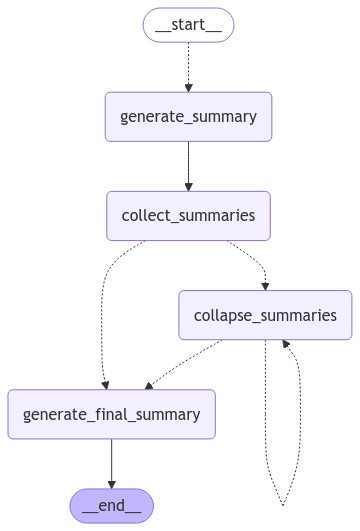

In [35]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### Invoke graph

When running the application, we can stream the graph to observe its sequence of steps. Below, we will simply print out the name of the step.

Note that because we have a loop in the graph, it can be helpful to specify a [`recursion_limit`](https://langchain-ai.github.io/langgraph/reference/errors/#langgraph.errors.GraphRecursionError) on its execution. This will raise a specific error when the specified limit is exceeded.

In [36]:
doc_contents = [
    doc.page_content 
    for doc in split_docs
]

async for step in app.astream(
    input=OverallState(
        contents=doc_contents
    ),
    config={
        "recursion_limit": 10
    },
):
    print(list(step.keys())) 

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['generate_final_summary']


In [37]:
print(step["generate_final_summary"]["final_summary"])

A narrator invites his friend Fortunato to explore the vaults beneath their family's estate or an underground catacombs, promising a rare bottle of wine. As they journey deeper into the crypts, Fortunato becomes increasingly agitated and confused by the surroundings and the narrator's behavior. The narrator eventually leads Fortunato to a small recess where he is met with horror, bound to the wall, and left helpless and trapped.


In the corresponding [LangSmith trace](https://smith.langchain.com/public/f1bd0d9e-ed33-4897-af33-518417df9e46/r) we can see the individual LLM calls, grouped under their respective nodes.

> Check out the following LangGraph how-to guide on the details of `Map-Reduce`: 
> 
> [How to create map-reduce branches for parallel execution](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/)

## Iterative Refinement

Iterative refinement is another strategy for summarizing long texts that does not fit into a model's context window. The strategy is as follows:

1. Split a long text into smaller chunks or sub-documents;
2. Summarize the first sub-document;
3. Refine or update the summary based on the next sub-document;
4. Repeat through the sequence of sub-documents until finished.

Note that this strategy is **not parallelized**. It is especially effective when understanding of a sub-document depends on earlier sub-documents. For example, when summarizing a story or any text with an inherent sequence.

> See also: [How to summarize text through iterative refinement](https://python.langchain.com/docs/how_to/summarize_refine/)

### Split into sub-documents

First we split a long text into smaller "sub-documents", similar to what we did for [`Map-Reduce`](#map-reduce-summarize-long-texts-via-parallelization).

In [38]:
from transformers import AutoTokenizer
from langchain_text_splitters import CharacterTextSplitter


llama_tokenizer = AutoTokenizer.from_pretrained("./llama-tokenizer")

text_splitter = CharacterTextSplitter.from_huggingface_tokenizer(
    tokenizer=llama_tokenizer,
    chunk_size=1000, 
    chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)

print(
    f"Generated {len(split_docs)} documents."
)

Generated 4 documents.


### Initial summary

Create a chain for the initial summary that plucks out the first sub-document, formats it into a prompt and runs inference with our LLM. We'll just reuse the same summarization prompt as in the [`stuff`](#stuff-summarize-text-in-a-single-llm-call) approach.

In [53]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    PromptTemplate, 
    ChatPromptTemplate
)

summarize_template = PromptTemplate.from_file(
    "prompts/summarize_template.txt"
)

summarize_prompt = ChatPromptTemplate.from_messages(
    messages=[
        (
            "human", 
            summarize_template.template
        )
    ]
)

initial_summary_chain = summarize_prompt | chat_model | StrOutputParser()

In [54]:
summarize_prompt.pretty_print()

================================ Human Message =================================

Write a plot summary of the following story in under 500 words. Only use the information provided in the story below to produce the plot summary. Your final answer should only be the plot summary and nothing else.

Story to summarize:
{context}

Plot summary:


### Refine the summary

Create a second chain that operates on each successive sub-document, refining the initial summary.

In [63]:
refine_template = PromptTemplate.from_file(
    "prompts/refine_template.txt"
)

refine_prompt = ChatPromptTemplate.from_messages(
    messages=[
        ("human", refine_template.template)
    ]
)

refine_summary_chain = refine_prompt | chat_model | StrOutputParser()

In [64]:
refine_prompt.pretty_print()

================================ Human Message =================================

Refine the original summary using additional information provided in the context below. Only use the information provided in the context below to refine the original summary. Your final answer should only be the new refined summary and nothing else.

Original summary:
{current_summary}

Context:
{new_context}

New refined summary (under 500 words):



### Create graph

Below we show a [`LangGraph`](https://langchain-ai.github.io/langgraph/) implementation of summarization using iterative refinement:

In [65]:
from typing import (
    Literal, 
    TypedDict
)

from langchain_core.runnables import RunnableConfig
from langgraph.graph import (
    START, 
    END,
    StateGraph
)


# We will define the state of the graph to hold the document
# contents and summary. We also include an index to keep track
# of our position in the sequence of documents.
class State(TypedDict):
    doc_contents: list[str]
    """Sequence of documents to summarize"""

    doc_index: int
    """Index of document in `doc_contents` to summarize."""

    summary: str
    """The summary generated from the documents processed so far."""


# Node that generates the initial summary for 
# the first sub-document
async def generate_initial_summary(
    state: State, 
    config: RunnableConfig
) -> State:
    first_doc = state["doc_contents"][0]

    summary = await initial_summary_chain.ainvoke(
        input=first_doc,
        config=config,
    )

    return State(
        summary=summary, 

        # Move on to second sub-document
        doc_index=1
    )


# Node that refines the summary based on the 
# next document
async def refine_summary(
    state: State, 
    config: RunnableConfig
) -> State:
    doc_contents = state["doc_contents"]
    index = state["doc_index"]
    
    summary = await refine_summary_chain.ainvoke(
        input={
            "current_summary": state["summary"], 
            "new_context": doc_contents[index]
        },
        config=config,
    )

    return State(
        summary=summary,

        # Move on to next sub-document in list
        doc_index=index + 1 
    )


# Conditional edge: 
# Checks whether we have summarized all the 
# documents in the list and should stop.
def should_refine(
    state: State
) -> Literal[
        "refine_summary", 
        END # type: ignore
    ]:
    doc_index = state["doc_index"]
    doc_count = len(
        state["doc_contents"]
    )
    
    if doc_index >= doc_count:
        return END
    else:
        return "refine_summary"

Now that we've defined the nodes as functions, let's connect it together in a graph:

In [66]:
graph = StateGraph(state_schema=State)

# Nodes:
graph.add_node(
    node="generate_initial_summary", 
    action=generate_initial_summary
)
graph.add_node(
    node="refine_summary", 
    action=refine_summary
)

# Edges:
graph.add_edge(
    start_key=START, 
    end_key="generate_initial_summary"
)
graph.add_conditional_edges(
    source="generate_initial_summary", 
    path=should_refine
)
graph.add_conditional_edges(
    source="refine_summary", 
    path=should_refine
)

app = graph.compile()

Let's visualize the graph structure that we just built:

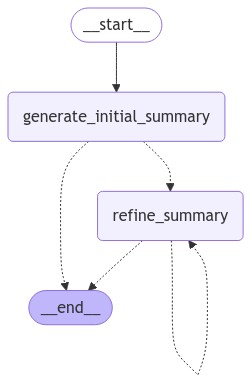

In [67]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

### Invoke graph

We can step through the execution as follows, printing out the summary as it is refined:

In [68]:
doc_contents = [
    doc.page_content 
    for doc in split_docs
]

async for step in app.astream(    
    input=State(doc_contents=doc_contents),
    stream_mode="values",
):
    if summary := step.get("summary"):
        print(summary)
        print("\n---------------------------------------\n")                    

The story follows the narrator's plan for revenge against his friend Fortunato, who has repeatedly insulted him. The narrator decides to punish Fortunato with impunity, ensuring that he will not be able to exact revenge on him. To achieve this, the narrator uses Fortunato's weakness - his connoisseurship in wine - to lure him into a trap.

The narrator encounters Fortunato at dusk during the carnival season and engages him in conversation about a pipe of Amontillado wine that the narrator has purchased. Fortunato is eager to taste the wine, despite the narrator's doubts about its authenticity. The narrator skillfully manipulates Fortunato's enthusiasm for wine, using it as bait to lure him into his palazzo.

Once inside, the narrator puts on a mask and leads Fortunato to his vaults, where he intends to bury him alive. As they walk, the narrator pretends to be concerned about Fortunato's health and the dampness of the vaults, all while secretly planning his revenge. Fortunato is oblivio

The final `step` contains the summary as synthesized from the entire set of sub-documents. In the corresponding [LangSmith trace](https://smith.langchain.com/public/317d1709-0387-47a5-8705-67a28a4b1df9/r) we can see the individual LLM calls, grouped under their respective nodes.